# ◆ 페르소나 분석
- 데이터 불러오기

In [157]:
import pandas as pd

In [159]:
df = pd.read_pickle('../data/aha/aha_data.pickle')

- 컬럼명 'review'로 바꿔주세요!

In [161]:
display(df.shape, df.head(3))

(4990, 3)

,제목,본문,작성일자
0,글루타치온 성분이 무엇인가요???,"티비에 글루타치온 ,리포좀 글루차티온 이러는데 항산화작용? 이걸한다는데 어떻게 몸...",6시간 전
1,고가 비타민영양제 꼭 챙겨야할까요?,생각보다 한병 자체에 값이 밥값반값 정도의 가격이라...부담스러운데 많이들 챙겨먹는...,6시간 전
2,벤포벨b 복용 후 타이레놀 먹어도 될까요,저녁6시쯤 벤포벨b 먹었습니다 지금 치통이 와서 타이레놀 먹어도 상관 없을까요?...,15시간 전


In [163]:
# '제목', '본문', '작성일자' -> 'title', 'review', 'date'
df.columns = ['title','review','date']

# ◆ 클러스터링

## ◆ 1. 데이터 전처리하기
* 1.1. 특수문자 및 숫자 제거
* 1.2. 의미없는 짧은 글 제거

### 1.1. 특수문자 및 숫자 제거
    *정규표현식 사용

In [3]:
import re
from tqdm import tqdm

In [169]:
# pattern = r'[^a-zA-Z0-9가-힣\s\.\?\!]'

pattern = r'[^a-zA-Z0-9가-힣\s]'

new_review = []
for i in tqdm(df['review']):
    text = re.sub(pattern,'',i)
    new_review.append(text)

df['review'] = new_review

100%|██████████| 4990/4990 [00:00<00:00, 188612.52it/s]


### 1.2. 의미없는 짧은 글 제거

In [171]:
# len(review) 가 짧으면 i, 인덱스를 추출해서 drop으로 없애기!
for i, review in enumerate(tqdm(df.review)):
    if len(review) < 15 :
        df = df.drop([i])
        # 왜 i 를 [] 로?!

100%|██████████| 4990/4990 [00:00<00:00, 2485697.98it/s]


### 1.3. 핵심 키워드를 포함한 글만 추출
    *주석 처리 해주겠습니다! (핵심 키워드 정리 되면 하세요!)

In [174]:
# 핵심 키워드 리스트에 넣어주세요!
keyword_list = []

In [5]:
# idx = []
# for i ,review in enumerate(tqdm(df.review)):
#     for keyword in keyword_list:
#         if keyword in review:
#             idx.append(i)
#             break

In [3]:
# # 핵심 키워드를 하나라도 포함하는 리뷰의 인덱스만 추출
# df = df.iloc[idx,:]
# df.reset_index(drop=True, inplace=True)

## ◆ 2. 데이터 형태소 분리하기
* 2.1 불용어적용 및 형태소 분리
* 2.2 데이터 프레임에 추가

In [5]:
from konlpy.tag import Okt
okt = Okt()

### 2.1. 불용어적용 및 형태소 분리
    *제공되는 한국어 불용어 파일 사용(ko-stopwords.csv) <- 핵심 1팀 - 파일 - data

In [180]:
stopwords_DF = pd.read_csv('../data/ko-stopwords.csv')
stopwords = list(stopwords_DF.stopwords)
len(stopwords)

599

    *추가 불용어 넣기

In [183]:
stopwords += ['비타민'] # 아래와 같이 넣기!!

In [185]:
len(stopwords)

600

In [189]:
def okt_pos_tagging(string):
    pos_words = okt.pos(string, stem=True, norm=True)
    # stem : 어근화 | norm : 정규화
    
    tagged_list = []
    for word, tag in pos_words:
        # 형태소 분리
        if tag in ['Noun','Adjective','Verb']:
            # 불용어 제거
            if word not in stopwords:
                tagged_list.append(word)
    # words = [word for word, tag in pos_words if tag in ['Noun','Adjective','Verb'] 
    #          if word not in stopwords]
    
    return tagged_list

### 2.2 데이터 프레임에 추가

    *아래 for문 생각보다 오래 걸렸어요! (수민님!)

In [193]:
tagged_list = []
for review in tqdm(df.review):
    tagged = okt_pos_tagging(review)
    tagged_list.append(tagged)

100%|██████████| 4990/4990 [00:53<00:00, 92.96it/s] 


In [204]:
df['tagged_review'] = tagged_list

### 2.3 n-grams

## ◆ 3. 벡터화
* 3.1 doc2vec 준비(문서의 순서 매기기)
* 3.2 doc2vec 학습시키기
* 3.3 벡터 값 데이터 프레임에 추가

In [149]:
#import gensim 안될때 첫번째시도
# pip install --upgrade scipy
# pip install --upgrade gensim

#두번쨰시도
#pip install --upgrade numpy

In [150]:
# !pip show scipy

In [7]:
import gensim #자연어 처리 및 토픽 모델링을 위한 라이브러리
from gensim.models.doc2vec import TaggedDocument
from gensim.models import doc2vec

### 3.1 doc2vec 준비
    - word2vec은 단어 하나를 하나의 vector화
    - doc2vec은 문서 하나를 하나의 vector화

In [209]:
# doc2vector
tagged_corpus_list = []  # 벡터 값이 들어갈 리스트
for i, token in enumerate(tqdm(df.tagged_review)):
    tag = 'document {}'.format(i)
    tagged_corpus_list.append(TaggedDocument(tags=[tag], words=token)) 

100%|██████████| 4990/4990 [00:00<00:00, 581959.10it/s]


In [211]:
tagged_corpus_list[0];

### 3.2 doc2vec 학습시키기
    <model 하이퍼파라미터 값>
    # vector_size : 생성할 문서 벡터의 크기
    # alpha: 모델 학습시 초기 학습률 0.025는 일반적으로 사용됨
    # min_alpha: 학습 과정에서 alpha 값을 이 값으로 줄여나가게 됩니다
    # window : 문맥 윈도우 크기, 주변 몇개의 단어의 문맥을 고려하여 학습하는가

In [213]:
model = doc2vec.Doc2Vec(vector_size=100, min_alpha=0.025, window=5)

In [215]:
# Vocabulary 빌드
model.build_vocab(tagged_corpus_list)

model.train(tagged_corpus_list, total_examples=model.corpus_count, epochs=5)
# moedel.corpus_count : 각 형태소 카운팅.
# epochs : for문이라 생각 몇 번 학습 할꺼냐?
# 너무 많이 학습하면, 주어진 데이터에 과적합 할 수 있음.
# 한 번 학습할 때, 텍스트가 흩뿌려지고 가까이 있는 데이터 값을 가지고 의미/학습을 함. 

### 3.3 벡터 값 데이터 프레임에 추가

In [217]:
# 학습을 시킨 모델에서 벡터 값 가져오기
# 키 값이 아까 달아둔 tag 값 (document {i})

In [219]:
len(model.dv)

4990

In [221]:
vector_list = []

for i in tqdm(range(len(df))):
    # 원하는 벡터 값
    doc2vec = model.dv['document {}'.format(i)]
    vector_list.append(doc2vec)

100%|██████████| 4990/4990 [00:00<00:00, 970894.70it/s]


In [223]:
df['vector'] = vector_list

## ◆ 4. 병합 계층적 클러스터링
* 4.1 ward 기준으로 덴드로그램 그려보기
* 4.2 실루엣 지수 확인해서 토픽 갯수 정하기
* 4.3 가장 적절한 클러스터링 갯수 df에 삽입

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

### 4.1 ward 기준으로 덴드로그램 그려보기

In [229]:
linked = linkage(list(df['vector']), 'ward')

    *이미지 저장하고 싶으시면 아래 savefig 주석 푸세요!

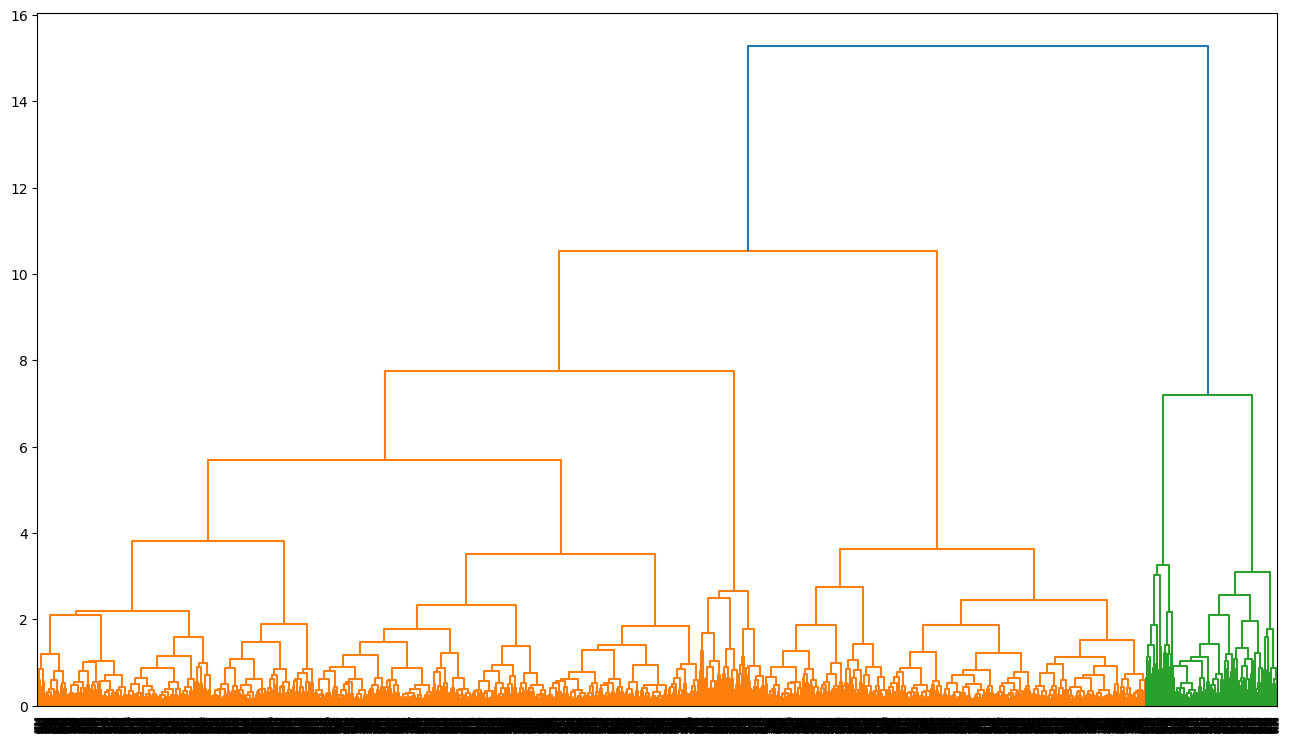

In [235]:
plt.figure(figsize=(16,9))
dendrogram(linked,
           orientation = 'top',          #방향 위쪽으로그려짐
           distance_sort = 'descending', #내림차순 정렬
           show_leaf_counts=True )
# plt.savefig('컬쳐_덴그로그램.png')
plt.show()

### 4.2 실루엣 지수 확인해서 토픽 갯수 정하기

In [11]:
from sklearn.metrics.cluster import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

클러스터 하나를 Actor로 보기로 했는데 클러스터가 너무 커버리면 해석하기가 어려움.

In [188]:
# import warnings
# warnings.filterwarnings('ignore')
# # import os
# # os.environ["OMP_NUM_THREADS"] = '10' # 사용할 thread 만큼 부여

In [240]:
# 몇 개를 기준으로 클러스터를 할 지
n_cluster = []
# 실루엣 score
s_score = []

for i in tqdm(range(2, 10, 1)):
    cluster = AgglomerativeClustering(n_clusters=i, linkage='ward')
    cluster_label = cluster.fit_predict(list(df['vector']))
    score = silhouette_score(list(df['vector']), cluster_label)

    n_cluster.append(i)
    s_score.append(score)

100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


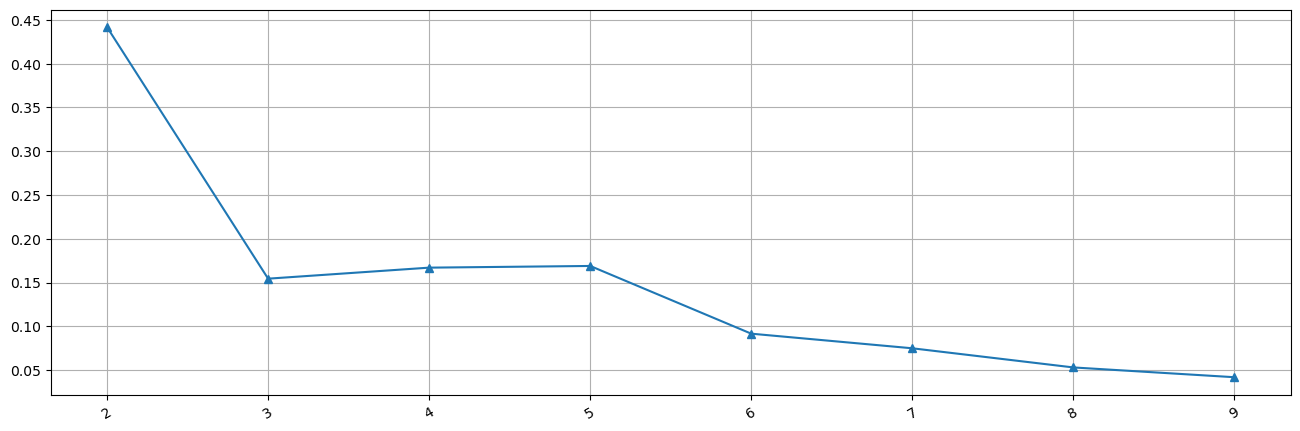

In [242]:
plt.figure(figsize=(16,5))
plt.plot(n_cluster, s_score, marker='^')
plt.grid()
plt.xticks(n_cluster,rotation=30)
plt.show()

(클러스터 갯수 설정하기!)

    *엘보우 기법에 의해 확 꺽이는 부분을
    *3과 4의 실루엣 지수가 비슷하면, 하나 적은 클래스터
    *클러스터 많아 질수록 실루엣 같은데, 다른 document를 배치 했을 때 클러스터 수가 적을 수록 적절한 클러스터로 갈 확률이 높기에

### 4.3 가장 적절한 클러스터링 갯수 df에 삽입

In [250]:
n_clusters = 3

In [252]:
result = pd.DataFrame({'n_cluster' : n_cluster, 'score' : s_score})

cluster = AgglomerativeClustering(n_clusters = n_clusters, linkage='ward')
cluster_label = cluster.fit_predict(list(df['vector']))

df['cluster'] = cluster_label

In [254]:
df.cluster.value_counts()

cluster
0    2926
2    1536
1     528
Name: count, dtype: int64

### 4.4 클러스터 별 파일 내보내기

In [257]:
df.cluster.unique()

array([0, 2, 1], dtype=int64)

    *내보낼 파일 명

In [264]:
df_name = 'aha_clutser'

    *파일 내보내기

In [266]:
for i in df.cluster.unique():
    df_pickle = df[df['cluster'] == i]
    df_pickle.to_pickle('../data/aha/cluster/{}{}.pkl'.format(df_name,i))

    #지금까지 Actor를 나누는 코드, 실습을 해왔음
    #각 Actor들이 그럼 어떤 desire, needs, pain point가 있는지 봐보자!

In [272]:
# # PICKLE 파일로 저장하기
# import pickle

# with open('컬쳐 클러스터링(3) 결과.pkl', 'wb') as file:
#     pickle.dump(df, file)

    *꼭 해야 하는 부분은 아닙니다!
---

## ◆ 5. 해석하기:TF-IDF
* 문서 내에서 어떤 단어가 얼마나 중요한지를 평가하는 데 사용되는 방법
* 5.1 TF-IDF 계산
* 5.2 데이터프레임으로 만들고 정렬하기

### 5.1 TF-idf 계산
* 각 클러스터 마다 tfidf가 높은 워드들 찾기
* 각 클러스터들을 하나의 문서로 가정하여 tf-idf 값 추출

In [13]:
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

    #각각의 클러스터의 주제를 찾는 것이기 떄문에,  
    #tf-idf 점수는 클러스터 별로 주제 단어를 배정해야 하니까 
    #6개의 클러스터 = 6개의 문서 => 문서 당 주제어를 뽑는다.

In [279]:
all_document = []
for i in df['cluster'].unique() : 
    
    pos_tagged = df[df['cluster']==i].tagged_review
    cluster_document = ''
    for pos in pos_tagged:
        doc = ' '.join(pos)
        cluster_document += doc

    all_document.append(cluster_document)

In [283]:
# 클러수터의 수와 동일해야 한다!
len(all_document)

3

In [284]:
# 모델 선언
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_document)

In [285]:
feature = vectorizer.get_feature_names_out()
dense = tfidf_matrix.todense()

tf_idf_df = pd.DataFrame(dense, columns=feature)

In [294]:
tf_idf_df_transposed = tf_idf_df.T
# tf_idf_df_transposed

    #각각의 클러스터 별로 높은 tf-idf 값을 가진 단어들을 보도록 정렬해서 저장하기

In [296]:
# tf_idf_df_transposed[0].sort_values(ascending=False)

### 5.2 데이터프레임으로 만들고 정렬하기

In [317]:
for i in tqdm(tf_idf_df_transposed.columns):
    tf_idf_data = tf_idf_df_transposed[i].sort_values(ascending = False)
    data = {'word' : tf_idf_data.index, 'tf_idf' : tf_idf_data.values}
    data_df = pd.DataFrame(data)

    data_df.to_csv('../data/aha/cluster/aha_cluster{}_tf-idf.csv'.format(i), encoding='utf-8-sig')

100%|██████████| 3/3 [00:00<00:00, 53.93it/s]


    *데이터 불러오기
    *globals() 활용 
[설명 링크](https://trustyou.tistory.com/197)

In [330]:
for i in df.cluster.unique():
    globals()["df_cluster{}_tf_idf".format(i)] = pd.read_csv('../data/aha/cluster/aha_cluster{}_tf-idf.csv'.format(i), index_col=0)

    *아래 코드를 위의 for문으로 만든겁니다 그냥 참고만 하시고 변수로 직접 불러와도 됩니다!

In [332]:
# df_cluster0_tf_idf0 = pd.read_csv('../data/cluster/aha_cluster0_tf-idf.csv',index_col=0)
# df_cluster1_tf_idf = pd.read_csv('../data/cluster/aha_cluster1_tf-idf.csv',index_col=0)
# df_cluster2_tf_idf = pd.read_csv('../data/cluster/aha_cluster2_tf-idf.csv',index_col=0)

    *추후 각 클러스터,Actor별 tf-idf확인 해보기! - Actor를 해석하기 위해서

In [345]:
df_cluster2_tf_idf.head(3)

,word,tf_idf
0,먹다,0.594788
1,양제,0.351264
2,복용,0.282635


In [339]:
# 클러스터 이름이 달린 파일 내보내기
df.to_pickle('../data/aha/cluster/aha_cluster.pkl')

---
# ◆ 클러스터(Actor) 별 Action 분석 - 선택

In [41]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import warnings
import re
from matplotlib import pyplot as plt
# warnings.filterwarnings('ignore')

    *데이터 불러오기

In [44]:
with open('../data/aha/cluster/aha_cluster.pkl', 'rb') as file:
    df = pickle.load(file)

In [46]:
df.head();

## ◆ 1. LDA를 위한 데이터 전처리
* 1.1. 전체 단어의 사전 만들고 각 문서에 매칭하기
    > 단어들이 문서에 얼마나 위치해 있는지 분포를 파악해야하기 때문에 분석할 전체 데이터 대상으로
    사용된 단어의 사전을 생성해야한다,

In [49]:
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary

In [51]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np

### 1.1 전체 단어의 사전 만들고 각 문서에 매칭하기

In [54]:
def preprocess_lda(df_cluster,tagged_review):
    all_documents = list(df_cluster[tagged_review])
    dictionary = Dictionary(all_documents)
    
    corpus = []
    for doc in all_documents:
        corpus.append(dictionary.doc2bow(doc))
    
    return corpus, all_documents, dictionary

In [59]:
# corpus = preprocess_lda(df_cluster,"tagged_review")

## ◆ 2. LDA모델 만들기
* 2.1 LDA 기본 모델 만들기
* 2.2 LDA 토픽개수 선정
* 2.3 선정한 토픽 개수로 Action 넘버 매칭

### 2.1 LDA 기본 모델 만들기
* skip

### 2.2.1 LDA 토픽개수 선정
* cohearence & perplexcity

In [56]:
def plot_for_topic(df_cluster,tagged_review,n):
    corpus, all_documents, dictionary =  preprocess_lda(df_cluster,tagged_review)
    
    perplex_values = []
    
    for i in range(2,10):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
        perp_v = ldamodel.log_perplexity(corpus)
        perplex_values.append(perp_v)

    coherence_values = []

    for i in range(2,10):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
        coherence_model = CoherenceModel(model = ldamodel, texts = all_documents, dictionary = dictionary, topn = i)
        coherence_score = coherence_model.get_coherence()
        coherence_values.append(coherence_score)

    fig, axes = plt.subplots(2,1, figsize =(16,8))

    # > 2.2.1 Perplexity 그래프 만들기
    x = range(2,10)
    axes[0].plot(x, perplex_values, marker='o')
    axes[0].set_xlabel("Actor{}_Number of topics".format(n))
    axes[0].set_ylabel('Perplexity score')

    # > 2.2.1 Cohearence 그래프 만들기
    x = range(2,10)
    axes[1].plot(x, coherence_values, marker='o')
    axes[1].set_xlabel('Actor{}_Number of topics'.format(n))
    axes[1].set_ylabel('Coherence score')

    # 저장하고 싶다면!!
    # plt.savefig('../data/number_of_topics.png')
    
    return plt.show()

In [20]:
df.cluster.value_counts();

    *클러스터 n번을 대상으로 cohearence & perplexcity 확인하기

  0%|          | 0/3 [00:00<?, ?it/s]

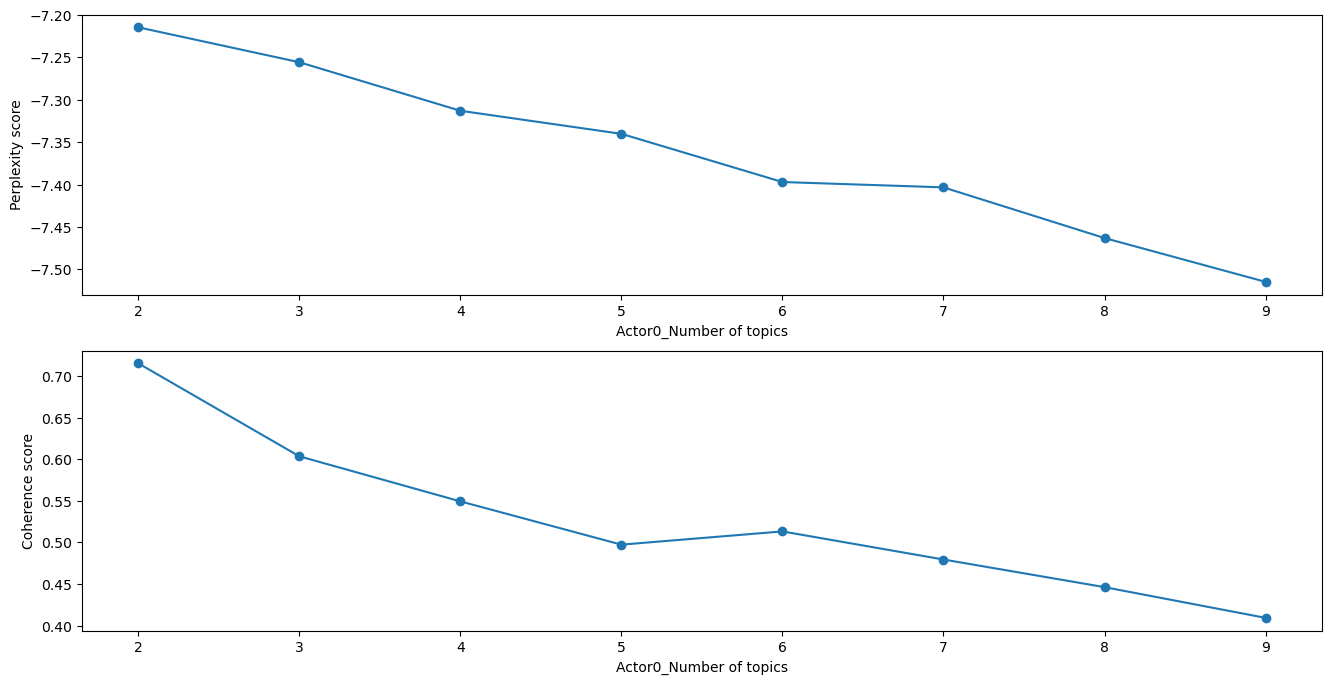

 33%|███▎      | 1/3 [01:17<02:34, 77.45s/it]

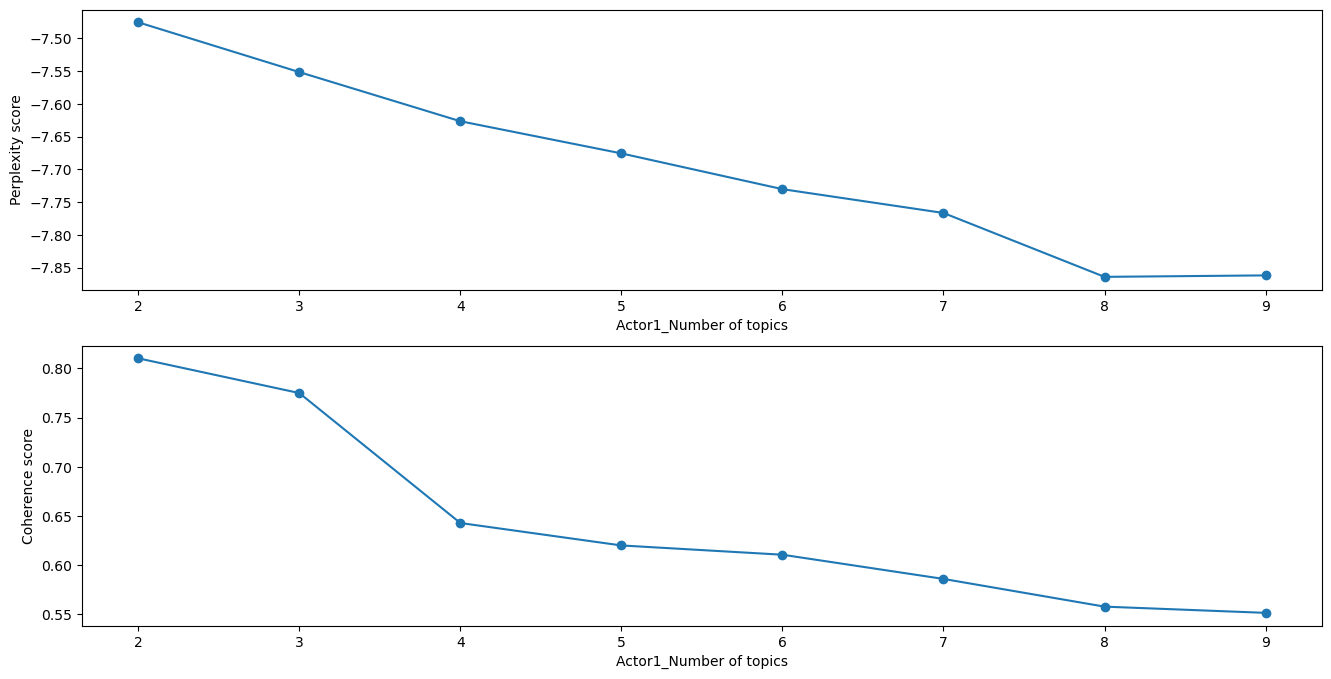

 67%|██████▋   | 2/3 [02:20<01:08, 68.83s/it]

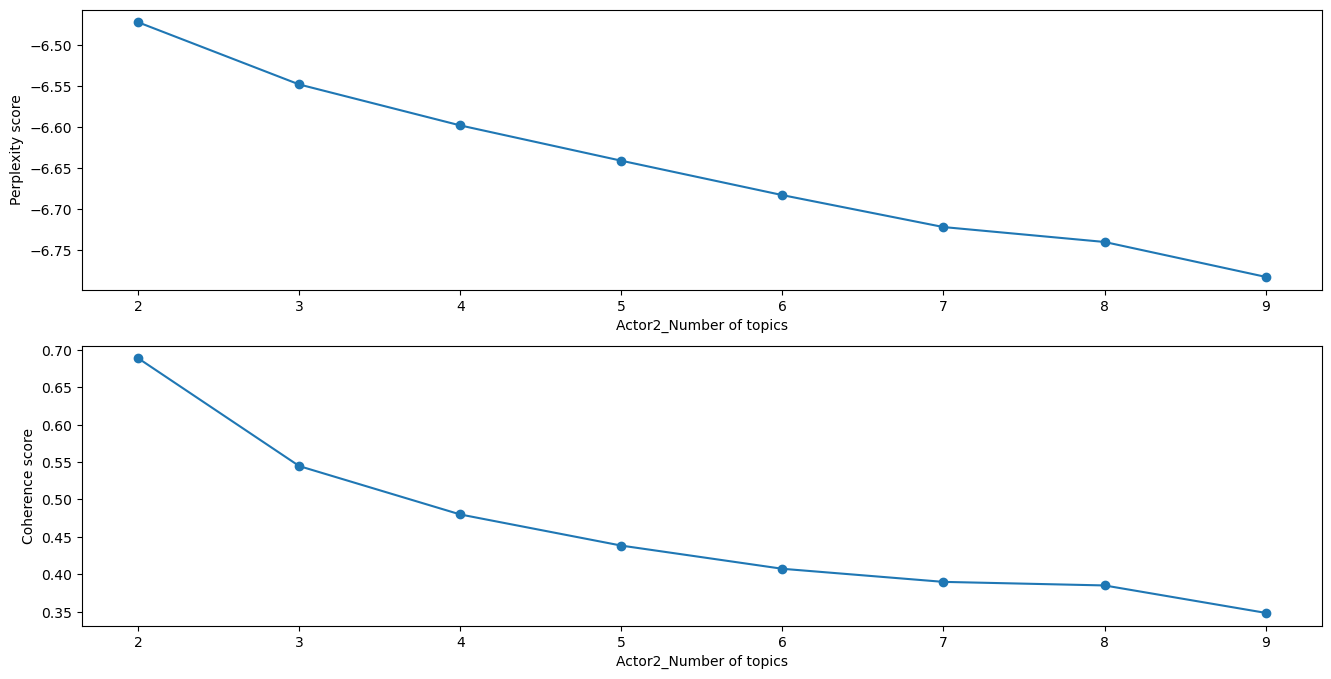

100%|██████████| 3/3 [03:31<00:00, 70.56s/it]


In [134]:
for n in tqdm(range(len(df.cluster.unique()))):
    df_cluster = df[df['cluster'] == n]
    plot_for_topic(df_cluster,"tagged_review",n)

### 2.2.2 LDA 토픽개수 선정
    *위 그래프를 보고 각 Actor별 Action 수 정하기!
    *클러스터 = Actor 수 만큼 action_n 변수 생성해야 합니다! 아래는 예제 입니다!
    *그래프 제목에 나오는 Actor 번호 순서와 아래 for문의 Actor 번호 순서 동일합니다! - 그래도 유의하세요!

In [58]:
action_n_list = []
for i in range(len(df.cluster.unique())):
    globals()["actor{}_action_n".format(i)] = int(input("Actor{}의 정한 액션 Number를 입력하세요 : ".format(i)))
    action_n_list.append(globals()["actor{}_action_n".format(i)])

Actor0의 정한 액션 Number를 입력하세요 :  5
Actor1의 정한 액션 Number를 입력하세요 :  4
Actor2의 정한 액션 Number를 입력하세요 :  3


    *input함수로 인해 마우스로 클릭해야 키보드가 작동합니다.

In [60]:
# Actor(index) acion_n 를 담은 리스트 확인 
action_n_list

[5, 4, 3]

In [62]:
# 리스트 넣으면 html Actor 수 만큼 나오게!

### 2.3 선정한 토픽 개수로 Action 넘버 매칭

- 선정한 토픽 개수로 모델링, 토픽화

- 토픽별 확률을 확인 해 max(확률 값)의 인덱스 = 토픽 라벨링

In [70]:
def action_labeling(df,action_n_list):
    # Action 라벨링을 한 Cluster = Actor 들의 리스트 [df_cluster0_action,df_cluster1_action,df_cluster2_action,...] 
    df_cluster_action_list = []
    # 아래 LDAvis 시각화를 위해 필요한 요소들을 담을 리스트
    ldavis_list = []
    
    for i in tqdm(range(len(df.cluster.unique()))):
        df_cluster = df[df.cluster == i]
        actor_action_n = action_n_list[i]
        
        corpus, all_documents, dictionary = preprocess_lda(df_cluster,"tagged_review")
        
        topic_num = actor_action_n
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = topic_num, id2word = dictionary,
                                                   random_state = 216, passes = 5)
        # 토픽을 선정 했으니, 계속 같은 결과 나오게 RandomSeed 고정 시키기

# --- 토픽별 확률을 확인 해 max(확률 값)의 인덱스 = 토픽 라벨링

        action_align = []
        # 라벨을 담을 리스트
        
        for doc in tqdm(ldamodel.get_document_topics(corpus)):
        # 0번 리뷰에 대한 [(토픽 넘버, 확률 값)(토픽 넘버, 확률 값),(토픽 넘버, 확률 값)]
        # 1번 리뷰에 대한 [(토픽 넘버, 확률 값)(토픽 넘버, 확률 값),(토픽 넘버, 확률 값)]
            
            label = []
        # 토픽 넘어 담을 리스트
            value = []
        # 확률 값을 담을 리스트
            
            for score in doc:
                label.append(score[0])
                value.append(score[1])
        
            max_index = np.argmax(value)
            action_n = label[max_index]
            action_align.append(action_n)
    
        df_cluster['action_cluster'] = action_align
        
        df_cluster_action_list.append(df_cluster)
        ldavis_list.append([ldamodel, corpus, dictionary])

        # ldavis_list[i][0] = ldamodel
        # ldavis_list[i][1] = corpus
        # ldavis_list[i][2] = dictionary
        
        # prepared_data = gensimvis.prepare(ldamodel, corpus, dictionary)

    return df_cluster_action_list, ldavis_list

In [289]:
df_cluster_action_list, ldavis_list = action_labeling(df,action_n_list)

100%|██████████| 2926/2926 [00:02<00:00, 1293.92it/s]
C:\Users\trainee216\AppData\Local\Temp\ipykernel_30632\410188951.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['action_cluster'] = action_align
100%|██████████| 528/528 [00:00<00:00, 1241.91it/s]
C:\Users\trainee216\AppData\Local\Temp\ipykernel_30632\410188951.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['action_cluster'] = action_align
100%|██████████| 1536/1536 [00:01<00:00, 1060.76it/s]
C:\Users\trainee216\AppData\

In [291]:
# 클러스터 0번에 대한 action 라벨링 확인
for i in range(len(df.cluster.unique())):
    display(df_cluster_action_list[i].action_cluster.value_counts().sort_index())

action_cluster
0     367
1     634
2    1048
3     475
4     402
Name: count, dtype: int64

action_cluster
0     97
1    148
2    136
3    147
Name: count, dtype: int64

action_cluster
0    508
1    198
2    830
Name: count, dtype: int64

## ◆ 3. LDA 시각화 (LDAvis)


In [477]:
# !pip install pyLDAvis

In [293]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [295]:
def save_ldavis_html(ldavis_list):
    prepared_data_list = []

    for i in range(len(ldavis_list)):
        prepared_data = gensimvis.prepare(ldavis_list[i][0], ldavis_list[i][1], ldavis_list[i][2])
        # 저장하기
        pyLDAvis.save_html(prepared_data, 'cluster{}_ldavis_action.html'.format(i))

        prepared_data_list.append(prepared_data)

    return prepared_data_list

In [79]:
prepared_data_list = save_ldavis_html(ldavis_list)

    *저장되어 있는 html을 불러와서 비교해도 되고 아래 코드를 실행해 모든 Actor의 Map을 봐도 됩니다!
    *(아마 아래 있는 코드 실행해서 하게 제가 그냥 만들었어요!)

In [82]:
# df_cluster_action_list[0].action_cluster.unique(), prepared_data_list[0].topic_order

## ◆ 4. LDA 분석을 위한 후작업
* LDAvis와 LDA모델의 토픽 넘버 매칭
* LDAvis 결과와 LDA모델의 결과를 보고 직접 매칭해야한다.

### 4.1 LDAvis 결과와 LDA모델의 결과를 보고 직접 매칭

    *그래프의 1번 원이 1번 action_clutsr를 의미하지 않음! = 완전 무작위로 선정되어 있음
    *=> 수작업으로 해줘야 함!

In [404]:
def new_action_topic_labeling(cluster_num,df_cluster,prepared_data_list,ldavis_list):
    display("Cluster = Actor {}의 Map".format(cluster_num), pyLDAvis.display(prepared_data_list[cluster_num]))
    
    ldamodel = ldavis_list[cluster_num][0]
    
    topics = ldamodel.show_topics(num_topics=-1, formatted = True)
    display("{}번 클러스터에 대한 주제 단어들!".format(cluster_num), topics)
    
    action_dict = {}
    
    for j in range(len(topics)):
        new_action_num = int(input("\n보고 계신 원의 번호를 입력해 주세요! : "))
        origin_action_num = int(input("위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! : "))
        
        if origin_action_num in action_dict.keys():
            print("잘 못 입력했습니다! 처음 설정한 토픽 번호에 대해서 각 각 다른 하나의 원을 매칭해야 합니다!")
            return
        else:
            action_dict[origin_action_num] = new_action_num
    
    return action_dict

    *따로 따로 하나 하고 싶으신 분들은 아래 코드와 같이 df_cluster0 = df_cluster_action_list[0] # df_cluster_action_list 에서 df_cluster로 하나씩 빼서 하세요!

In [407]:
# df_cluster_action_list = df_cluster0, df_cluster1, df_cluster2, ... 를 담은 리스트
# df_cluster0 = df_cluster_action_list[0]

In [409]:
df_cluster0 = df_cluster_action_list[0].copy()

In [424]:
action_dict = new_action_topic_labeling(0,df_cluster0,prepared_data_list,ldavis_list)

'Cluster = Actor 0의 Map'

'0번 클러스터에 대한 주제 단어들!'

[(0,
  '0.019*"궁금하다" + 0.014*"약" + 0.012*"먹다" + 0.012*"성분" + 0.009*"아니다" + 0.008*"좋다" + 0.007*"복용" + 0.007*"양제" + 0.007*"피부" + 0.007*"효과"'),
 (1,
  '0.062*"먹다" + 0.016*"복용" + 0.016*"양제" + 0.011*"섭취" + 0.008*"괜찮다" + 0.008*"하루" + 0.007*"유산균" + 0.007*"궁금하다" + 0.007*"요" + 0.007*"마그네슘"'),
 (2,
  '0.028*"먹다" + 0.026*"양제" + 0.024*"좋다" + 0.016*"궁금하다" + 0.014*"보다" + 0.014*"복용" + 0.012*"들다" + 0.011*"없다" + 0.011*"제품" + 0.011*"효과"'),
 (3,
  '0.053*"먹다" + 0.029*"양제" + 0.027*"복용" + 0.020*"오메가" + 0.017*"아침" + 0.014*"유산균" + 0.014*"저녁" + 0.014*"후" + 0.013*"알" + 0.011*"마그네슘"'),
 (4,
  '0.037*"먹다" + 0.026*"양제" + 0.019*"복용" + 0.019*"약" + 0.009*"요" + 0.008*"알다" + 0.008*"궁금하다" + 0.008*"정" + 0.008*"섭취" + 0.007*"논"')]


보고 계신 원의 번호를 입력해 주세요! :  2
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  1

보고 계신 원의 번호를 입력해 주세요! :  1
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  2

보고 계신 원의 번호를 입력해 주세요! :  3
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  3

보고 계신 원의 번호를 입력해 주세요! :  4
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  4

보고 계신 원의 번호를 입력해 주세요! :  0
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  5


In [417]:
action_dict

{2: 1, 1: 2, 3: 3, 4: 4, 0: 5}

### 4.2 LDAvis와 LDA모델의 토픽 넘버 매칭

    *한번에 하실 분은 아래 for문으로!
    *혹시라도 실수할 수 도 있으니 copy를 만들어서 진행!

In [494]:
test_list = [df.copy() for df in df_cluster_action_list]

In [450]:
for i in range(len(test_list)):
    df_cluster = test_list[i]
    action_dict = new_action_topic_labeling(i,df_cluster,prepared_data_list,ldavis_list)

    # 넘버 매칭
    df_cluster.loc[:,'action_cluster'] = df_cluster.action_cluster.replace(action_dict)
    # 위에 리스트에서 인덱스로 빼서 변수에 넣고 값을 바꾸더라도 해당 리스트내의 df로 바뀝니다! -> copy로 혹시 모를 실수 방지!

'Cluster = Actor 0의 Map'

'0번 클러스터에 대한 주제 단어들!'

[(0,
  '0.019*"궁금하다" + 0.014*"약" + 0.012*"먹다" + 0.012*"성분" + 0.009*"아니다" + 0.008*"좋다" + 0.007*"복용" + 0.007*"양제" + 0.007*"피부" + 0.007*"효과"'),
 (1,
  '0.062*"먹다" + 0.016*"복용" + 0.016*"양제" + 0.011*"섭취" + 0.008*"괜찮다" + 0.008*"하루" + 0.007*"유산균" + 0.007*"궁금하다" + 0.007*"요" + 0.007*"마그네슘"'),
 (2,
  '0.028*"먹다" + 0.026*"양제" + 0.024*"좋다" + 0.016*"궁금하다" + 0.014*"보다" + 0.014*"복용" + 0.012*"들다" + 0.011*"없다" + 0.011*"제품" + 0.011*"효과"'),
 (3,
  '0.053*"먹다" + 0.029*"양제" + 0.027*"복용" + 0.020*"오메가" + 0.017*"아침" + 0.014*"유산균" + 0.014*"저녁" + 0.014*"후" + 0.013*"알" + 0.011*"마그네슘"'),
 (4,
  '0.037*"먹다" + 0.026*"양제" + 0.019*"복용" + 0.019*"약" + 0.009*"요" + 0.008*"알다" + 0.008*"궁금하다" + 0.008*"정" + 0.008*"섭취" + 0.007*"논"')]


보고 계신 원의 번호를 입력해 주세요! :  1
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  2

보고 계신 원의 번호를 입력해 주세요! :  2
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  1

보고 계신 원의 번호를 입력해 주세요! :  3
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  3

보고 계신 원의 번호를 입력해 주세요! :  4
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  4

보고 계신 원의 번호를 입력해 주세요! :  5
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  0


'Cluster = Actor 1의 Map'

'1번 클러스터에 대한 주제 단어들!'

[(0,
  '0.015*"먹다" + 0.011*"양제" + 0.009*"알" + 0.007*"궁금하다" + 0.006*"마그네슘" + 0.006*"보다" + 0.006*"칼슘" + 0.006*"성분" + 0.005*"섭취" + 0.005*"저녁"'),
 (1,
  '0.034*"먹다" + 0.019*"양제" + 0.011*"복용" + 0.009*"정" + 0.008*"마그네슘" + 0.007*"유산균" + 0.007*"오메가" + 0.006*"궁금하다" + 0.006*"아침" + 0.006*"섭취"'),
 (2,
  '0.021*"복용" + 0.019*"먹다" + 0.018*"양제" + 0.017*"알" + 0.012*"나우" + 0.011*"푸드" + 0.010*"오메가" + 0.010*"마그네슘" + 0.010*"정" + 0.008*"섭취"'),
 (3,
  '0.031*"먹다" + 0.012*"양제" + 0.010*"보다" + 0.010*"좋다" + 0.009*"복용" + 0.007*"요" + 0.006*"약" + 0.006*"없다" + 0.006*"궁금하다" + 0.005*"수"')]


보고 계신 원의 번호를 입력해 주세요! :  1
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  1

보고 계신 원의 번호를 입력해 주세요! :  2
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  2

보고 계신 원의 번호를 입력해 주세요! :  3
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  3

보고 계신 원의 번호를 입력해 주세요! :  4
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  0


'Cluster = Actor 2의 Map'

'2번 클러스터에 대한 주제 단어들!'

[(0,
  '0.072*"먹다" + 0.026*"양제" + 0.022*"좋다" + 0.022*"복용" + 0.013*"오메가" + 0.013*"섭취" + 0.010*"궁금하다" + 0.010*"요" + 0.010*"효과" + 0.010*"제품"'),
 (1,
  '0.042*"유산균" + 0.029*"복용" + 0.028*"먹다" + 0.023*"양제" + 0.015*"궁금하다" + 0.012*"좋다" + 0.011*"섭취" + 0.011*"없다" + 0.011*"괜찮다" + 0.009*"칼슘"'),
 (2,
  '0.079*"먹다" + 0.041*"양제" + 0.025*"복용" + 0.019*"좋다" + 0.016*"오메가" + 0.016*"궁금하다" + 0.013*"마그네슘" + 0.011*"안녕하다" + 0.010*"섭취" + 0.009*"요"')]


보고 계신 원의 번호를 입력해 주세요! :  1
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  2

보고 계신 원의 번호를 입력해 주세요! :  2
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  0

보고 계신 원의 번호를 입력해 주세요! :  3
위의 주제 단어과 매칭되는 처음에 설정한 Action 토픽 번호를 입력해 주세요! :  1


    *제대로 다 한 것 같다면?!

In [500]:
df_cluster_action_list = test_list

## ◆ 5. 각 Actor에 LDAvis 결과로 Action (토픽) 넘버한 결과 통합하기
* df_cluster_action_list 내의 모든 df들을 병합하기 
* 데이터 내보내기

In [515]:
df_final = pd.concat(df_cluster_action_list)

In [521]:
# action_cluster 컬럼이 추가 된 것을 확인!
df.shape, df_final.shape

((4990, 6), (4990, 7))

In [523]:
df_final.to_pickle("../data/aha/aha_data_action.pkl")

---
# ◆ 기회영역 그래프 만들기
- 데이터 불러오기

In [525]:
df = pd.read_pickle("../data/aha/aha_data_action.pkl")

In [527]:
df.shape

(4990, 7)

## ◆ 1. Satisfaction
* 1.1 감성사전 불러오기 (SentiWord_info.json)
* 1.2 감성점수 구하는 define 함수 만들기
* 1.3 감성점수 구하기
* 1.4 액션 별로 감성점수 계산해서 df에 추가하기

### 1.1 감성사전 불러오기

In [531]:
import json

with open('../data/SentiWord_info.json', encoding ='utf-8-sig', mode='r') as f:
    sent_dicts = json.load(f)

### 1.2 감성점수 구하는 define 함수 만들기

In [533]:
# 토큰 리스트
# 위의 감성 사전 word에 토큰이 있는지 있다면 = polarity를 가져 옴
# token_list = tagged_review

def sentiment_score(sent_dicts, token_list):
    result_list = []

    for token in token_list:
        for dict in sent_dicts:
            if token == dict['word']:
                result = dict['polarity'], dict['word']
                result_list.append(result)
    
    return result_list

In [543]:
df['tagged_review'] = df['tagged_review'].apply(lambda x : str(x)).apply(eval)

### 1.3  감성점수 구하기

#### 1.3.1 적합하게 형태소 재분리

In [551]:
from konlpy.tag import Okt
okt = Okt()

In [552]:
# 이번에는 불용어 처리 안 함!
# tag값 은 원래대로 동일하게 사용하되, 

def okt_pos_tagging(string):
    pos_words = okt.pos(string, stem=True, norm=True)
    # stem : 어근화 | norm : 정규화
    
    tagged_list = []
    for word, tag in pos_words:
        if tag in ['Noun','Adjective','Verb','VerbPrefix']:
            tagged_list.append(word)

    return tagged_list

#### 1.3.2 감성점수 적용하기

In [556]:
# 감성 점수 받을 리스트
sentiment = []

for i in tqdm(df['review']):
    token = okt_pos_tagging(i)
    score = sentiment_score(sent_dicts, token)
    sentiment.append(score)

100%|██████████| 4990/4990 [08:04<00:00, 10.30it/s]


In [559]:
# 감성 점수 평균 구하기
sentiment_score = []

for sent in tqdm(sentiment):
    score = []
    for s in sent:
        score.append(int(s[0]))
    
    if len(score) == 0:
        sentiment_score.append(0)
    else:
        sentiment_score.append(np.mean(score))

100%|██████████| 4990/4990 [00:00<00:00, 34033.66it/s]


In [561]:
df['sentiment_score'] = sentiment_score

### 1.4 전체 액터와 액션에 대해서 감성점수 계산


#### 1.4.1 dict 형식으로 출력


In [563]:
df.cluster.unique()

array([0, 1, 2], dtype=int64)

In [565]:
# key : actor와 action
# vale : sentiment_score

action_sents = dict()

for actor in df.cluster.unique():
    actor_df = df[df['cluster'] == actor]

    for action in actor_df.action_cluster.unique():
        action_score = actor_df[actor_df['action_cluster'] == action].sentiment_score
        action_score = np.mean(action_score)
        action_sents['Actor{}_Action{}'.format(actor, action)] = action_score        

In [567]:
action_sents

{'Actor0_Action2': 0.254092072579668,
 'Actor0_Action1': 0.056495554918267854,
 'Actor0_Action4': 0.141325748601868,
 'Actor0_Action5': -0.0680993469140608,
 'Actor0_Action3': 0.31060127591706543,
 'Actor1_Action3': -0.015969256870617416,
 'Actor1_Action1': 0.23417476312213156,
 'Actor1_Action2': 0.08735020086123026,
 'Actor1_Action4': 0.09364595885214443,
 'Actor2_Action1': 0.30579927509061366,
 'Actor2_Action3': 0.2931937496139831}

#### 1.4.2 정규화 (-10~10)
* minmaxscaler를 이용해서 정규화 : 주어진 데이터를 특정 범위로 변환(정규화)하는 데 사용
* minmaxscaler은 배열(array 데이터 형식, shape이 1이어야 작동)로 변환필요 

In [570]:
from sklearn.preprocessing import MinMaxScaler

In [572]:
data = action_sents.values()
# 데이터 타입 변환
# array로 보면 값이 하나, 리스트가 하나 - 행이 하나 => 행렬 값으로 변환
data = np.array(list(data)).reshape(-1, 1)

In [574]:
scaler = MinMaxScaler(feature_range=(-10, 10))
transposed_data = scaler.fit_transform(data)

In [576]:
score_result = transposed_data.flatten().tolist()
#                      차원을 1차원을 풀어주고 | 리스트로 변환 

In [578]:
for key, new_value in zip(action_sents.keys(), score_result):
    action_sents[key] = new_value

In [580]:
action_sents

{'Actor0_Action2': 7.015626596283864,
 'Actor0_Action1': -3.4198734134171622,
 'Actor0_Action4': 1.060192821986333,
 'Actor0_Action5': -10.0,
 'Actor0_Action3': 10.0,
 'Actor1_Action3': -7.246897052678483,
 'Actor1_Action1': 5.963750351210027,
 'Actor1_Action2': -1.790372742819037,
 'Actor1_Action4': -1.4578801293214543,
 'Actor2_Action1': 9.746395937215393,
 'Actor2_Action3': 9.080670838460973}

## ◆ 2. Importance
* 2.1 importance 점수 구하기 _ 전체 토픽의 비중
* 2.2 importance 점수 정규화

### 2-1. Importance 점수 구하기

In [582]:
from collections import Counter

In [607]:
importance_check = []

for actor, action in zip(df['cluster'],df['action_cluster']):
    importance_check.append('Actor'+str(actor)+'_'+'Action'+str(action))

In [609]:
frequency = Counter(importance_check)

# 중요도 사전 만들기
importance_dict = dict()

# 전체 합
total_count = sum(frequency.values())

# 빈도수 / 전체 값 * 100
# item : actor, action
# value : actor, action의 횟수
for item, value in frequency.items():
    importance = (value/total_count) * 100
    importance_dict[item] = importance

### 2-2. Importance 점수 정규화(0~10)

In [611]:
data = importance_dict.values()

# array 형태로 변환
data = np.array(list(data)).reshape(-1,1)

In [613]:
scaler = MinMaxScaler(feature_range=(0, 10))
transposed_data = scaler.fit_transform(data)

In [614]:
score_result = transposed_data.flatten().tolist()
score_result = [round(i,4) for i in score_result]

In [617]:
# value 값 교체
for key, new_value in zip(importance_dict.keys(),score_result):
    importance_dict[key] = new_value

## ◆ 3. Opportunity
* 3.1 Opportunity score
* 3.2 Opportunity area

### 3.1 Opportunity score
Opportunity = Importance + Max(Importance-Satisfaction, 0)

In [619]:
def opportunity_score(satisfaction, importance):
    result = importance + max(importance - satisfaction, 0)
    return result

In [647]:
# 감성점수 / opportunity_score 데이터프레임 화
opportunity_df = pd.DataFrame(action_sents.items(), columns = ['Action','satisfaction'])
opportunity_df['importance'] = importance_dict.values()

In [649]:
opportunity_list = []
for i,j in zip(opportunity_df['satisfaction'],opportunity_df['importance']):
    score_result = opportunity_score(i,j)
    opportunity_list.append(score_result)

opportunity_df['opportunity_score'] = opportunity_list

In [651]:
# Action 정렬
opportunity_df.sort_values(by = 'Action',inplace = True)

    *기회 점수(satisfaction, importance) 수치 담고 있는 파일 내보내기    

In [632]:
# csv 저장
# opportunity_df.to_csv('../data/coupang_Opportunity Score.csv', encoding = 'utf-8-sig')

### 3.2 Opportunity area

In [659]:
def show_opportunity_area(importance,satisfaction,actions,save_op=0):
    plt.figure(figsize = (15, 10))
    plt.scatter(importance, satisfaction, s=35, c=color) # s는 점의 사이즈 / c는 색상 
    
    # 라벨 이름
    plt.xlabel("Importance")
    plt.ylabel("Satisfaction")
    
    # 중요도 기준선
    xdata = [importance.mean(), 10]
    ydata = [-10,10]
    plt.plot(xdata, ydata, 'k')
    
    # 만족도 기준선
    xdata = [0, 10]
    ydata = [satisfaction.mean(),10]
    plt.plot(xdata, ydata, 'k')
    
    # 점에 이름 붙이기 + 위치 조정
    texts = []
    
    for i , action in enumerate(actions) :
        texts.append(plt.text(importance[i], satisfaction[i], action, fontsize = 13))
    
    # 위치조정
    adjust_text(texts, arrowprops = dict(arrowstyle='-', color='grey', lw=1))
    
    # 색상 범례추가
    for i, action in enumerate(actions):
        plt.scatter([], [], c = [color[i]], label=action, s=10)
    
    plt.legend(title='Actions', fontsize=8, title_fontsize='10', loc='upper left', bbox_to_anchor=(1,1))
    
    # 저장하기!
    if save_op == 1:
        plt.savefig('../data/aha/Opportunity_area.png')
        
    return plt.show()

In [483]:
# !pip install adjustText

In [634]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [636]:
opportunity_df.reset_index(drop=True,inplace=True)

In [638]:
# 데이터 세팅
satisfaction = opportunity_df.satisfaction
importance = opportunity_df.importance
actions = opportunity_df.Action

# 색상이 안 겹치게만 랜덤으로 설정
# actions의 개수 만큼 R,G,B 3개의 무작위 값 생성
color = np.random.rand(len(actions), 3)

    #위 그래프를 통해 서비스 우선순위를 정하는데 활용!!!!!

- 저장하고 싶다면! 아래 코드

In [665]:
# show_opportunity_area(importance,satisfaction,actions,save_op=1)

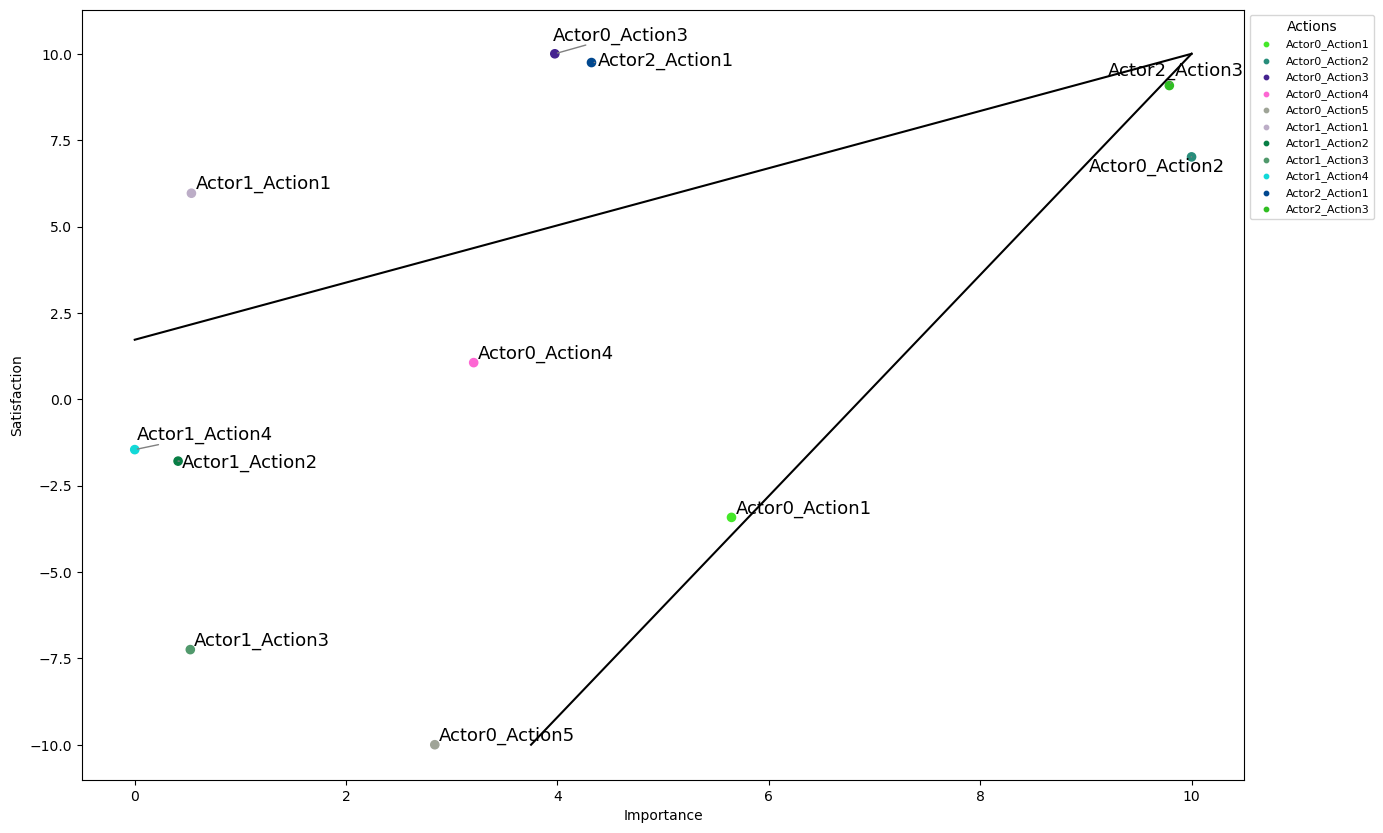

In [663]:
show_opportunity_area(importance,satisfaction,actions)